# **1.Import Library**

In [25]:
import os, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import models, transforms
from torchvision.datasets import ImageFolder

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import os
import cv2
from scipy.fftpack import dct, idct


from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score

!pip install kymatio
from kymatio.torch import Scattering2D

!pip install captum
from captum.attr import (
    Saliency,
    IntegratedGradients,
    InputXGradient,
    DeepLift,
    Occlusion,
    LayerGradCam
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

ERROR: Operation cancelled by user
Device: cpu


# **2. Load Dataset**

In [44]:
# ✅ Load binary image dataset from Google Drive (single cell)

import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# 🔹 Dataset base path
BASE_PATH = "/content/drive/MyDrive/CSV File/brain_tumor_dataset"

# Check path
assert os.path.exists(BASE_PATH), f"Dataset path not found: {BASE_PATH}"
print("Dataset contents:", os.listdir(BASE_PATH))

# 🔹 Image loading function (grayscale)
def load_images_from_folder(folder, label, img_size=(128, 128)):
    images, labels = [], []
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(label)
    return images, labels

# 🔹 Class folders (binary)
tumor_folder = os.path.join(BASE_PATH, "yes") # Corrected from 'tumor'
no_tumor_folder = os.path.join(BASE_PATH, "no") # Corrected from 'no_tumor'

# Load images
tumor_images, tumor_labels = load_images_from_folder(tumor_folder, label=1)
no_tumor_images, no_tumor_labels = load_images_from_folder(no_tumor_folder, label=0)

# Combine dataset
images = np.array(tumor_images + no_tumor_images)
labels = np.array(tumor_labels + no_tumor_labels)

# Normalize & reshape
images = images / 255.0
images = images.reshape((-1, 128, 128, 1))

# Train / test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset contents: ['no', 'yes']
Train shape: (202, 128, 128, 1)
Test shape: (51, 128, 128, 1)


**Printing The Shape of Dataset**

In [45]:
print(f"Training images shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing images shape: {X_test.shape}")
print(f"Testing labels shape: {y_test.shape}")
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Testing set class distribution: {np.bincount(y_test)}")

Training images shape: (202, 128, 128, 1)
Training labels shape: (202,)
Testing images shape: (51, 128, 128, 1)
Testing labels shape: (51,)
Training set class distribution: [ 78 124]
Testing set class distribution: [20 31]


Building CNN Model

In [46]:
pip install torch torchvision torchaudio

In [47]:
!pip install torchsummary

Model Training

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             320
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
           Dropout-5           [-1, 32, 64, 64]               0
            Conv2d-6           [-1, 64, 64, 64]          18,496
       BatchNorm2d-7           [-1, 64, 64, 64]             128
              ReLU-8           [-1, 64, 64, 64]               0
         MaxPool2d-9           [-1, 64, 32, 32]               0
          Dropout-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]          73,856
      BatchNorm2d-12          [-1, 128, 32, 32]             256
             ReLU-13          [-1, 128, 32, 32]               0
        MaxPool2d-14          [-1, 128,

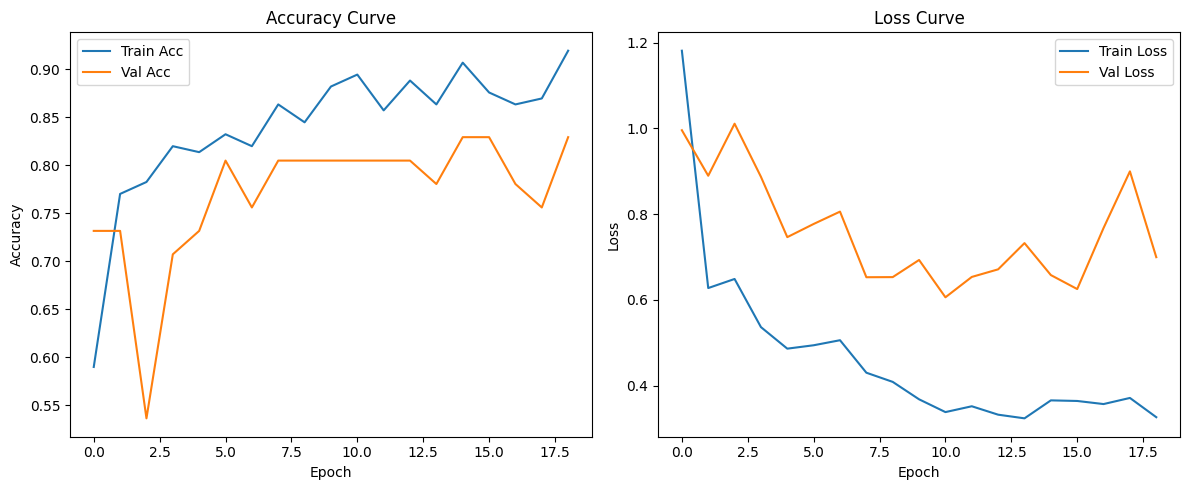

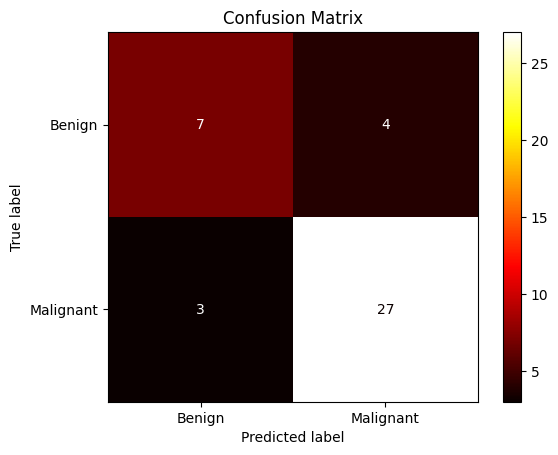

Fold 1 Accuracy: 0.8293, F1: 0.8852

===== Fold 2/5 =====
Epoch 01 | Train Acc: 0.6770 | Val Acc: 0.5610
Epoch 02 | Train Acc: 0.7267 | Val Acc: 0.5610
Epoch 03 | Train Acc: 0.8137 | Val Acc: 0.5610
Epoch 04 | Train Acc: 0.7826 | Val Acc: 0.5610
Epoch 05 | Train Acc: 0.8199 | Val Acc: 0.5610
Epoch 06 | Train Acc: 0.8261 | Val Acc: 0.5854
Epoch 07 | Train Acc: 0.8323 | Val Acc: 0.8293
Epoch 08 | Train Acc: 0.8634 | Val Acc: 0.6829
Epoch 09 | Train Acc: 0.8261 | Val Acc: 0.8293
Epoch 10 | Train Acc: 0.8634 | Val Acc: 0.8049
Epoch 11 | Train Acc: 0.8944 | Val Acc: 0.9024
Epoch 12 | Train Acc: 0.9068 | Val Acc: 0.8293
Epoch 13 | Train Acc: 0.7826 | Val Acc: 0.8537
Epoch 14 | Train Acc: 0.8758 | Val Acc: 0.8780
Epoch 15 | Train Acc: 0.8882 | Val Acc: 0.8780
Epoch 16 | Train Acc: 0.8571 | Val Acc: 0.8537
Epoch 17 | Train Acc: 0.8944 | Val Acc: 0.8780
Epoch 18 | Train Acc: 0.8634 | Val Acc: 0.9024
Epoch 19 | Train Acc: 0.9130 | Val Acc: 0.8537
Epoch 20 | Train Acc: 0.9441 | Val Acc: 0.8780
Ep

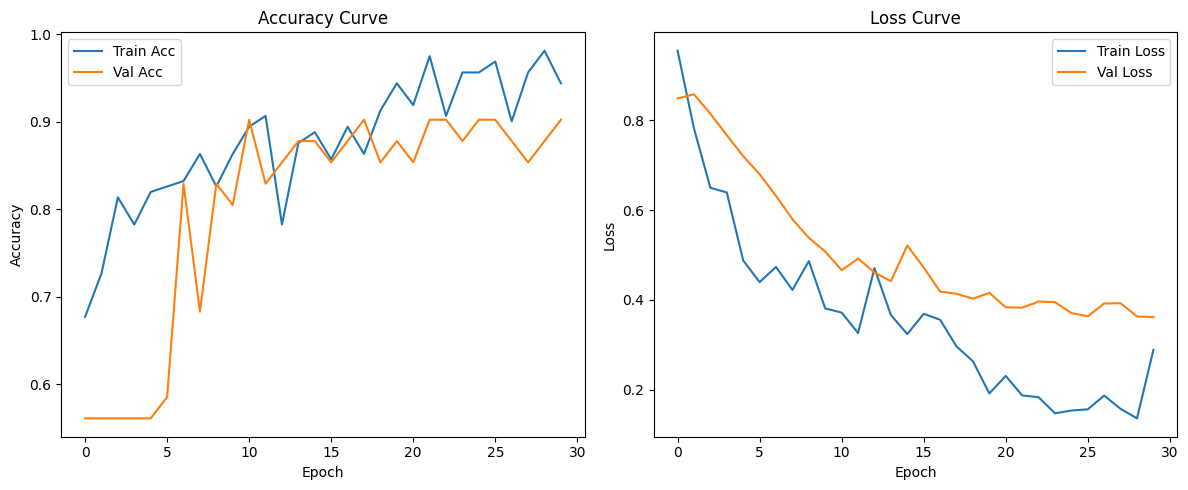

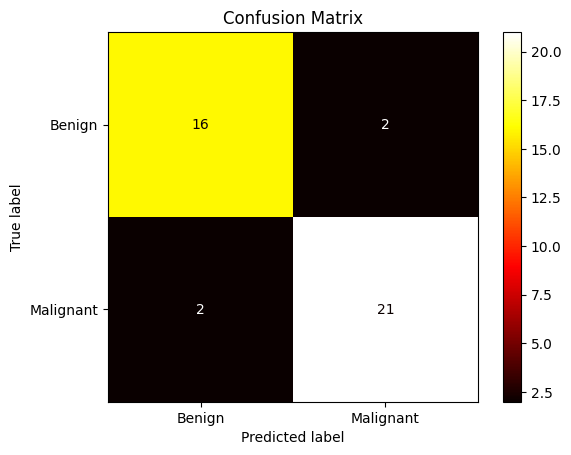

Fold 2 Accuracy: 0.9024, F1: 0.9130

===== Fold 3/5 =====
Epoch 01 | Train Acc: 0.6358 | Val Acc: 0.8000
Epoch 02 | Train Acc: 0.8086 | Val Acc: 0.4750
Epoch 03 | Train Acc: 0.7778 | Val Acc: 0.4750
Epoch 04 | Train Acc: 0.7963 | Val Acc: 0.7750
Epoch 05 | Train Acc: 0.8457 | Val Acc: 0.7750
Epoch 06 | Train Acc: 0.8519 | Val Acc: 0.8000
Epoch 07 | Train Acc: 0.8580 | Val Acc: 0.8500
Epoch 08 | Train Acc: 0.8765 | Val Acc: 0.7750
Epoch 09 | Train Acc: 0.8765 | Val Acc: 0.9250
Epoch 10 | Train Acc: 0.9259 | Val Acc: 0.8000
Epoch 11 | Train Acc: 0.8457 | Val Acc: 0.9250
Epoch 12 | Train Acc: 0.9198 | Val Acc: 0.8500
Epoch 13 | Train Acc: 0.9259 | Val Acc: 0.8000
Epoch 14 | Train Acc: 0.8148 | Val Acc: 0.8250
Epoch 15 | Train Acc: 0.9074 | Val Acc: 0.9250
Epoch 16 | Train Acc: 0.9136 | Val Acc: 0.8250
Epoch 17 | Train Acc: 0.9259 | Val Acc: 0.9250
Epoch 18 | Train Acc: 0.9568 | Val Acc: 0.8750
Epoch 19 | Train Acc: 0.9506 | Val Acc: 0.8750
Epoch 20 | Train Acc: 0.9691 | Val Acc: 0.8750
Ep

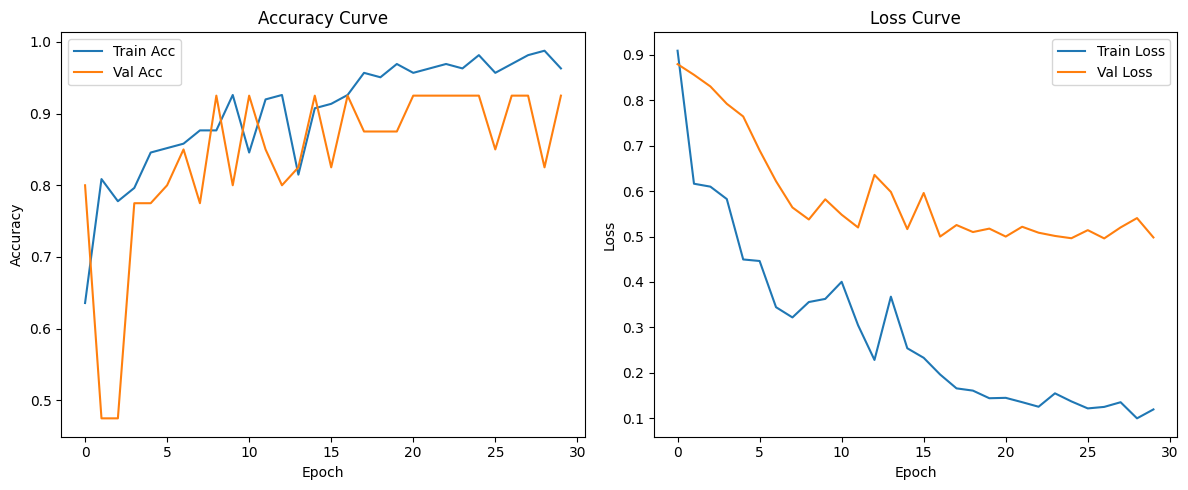

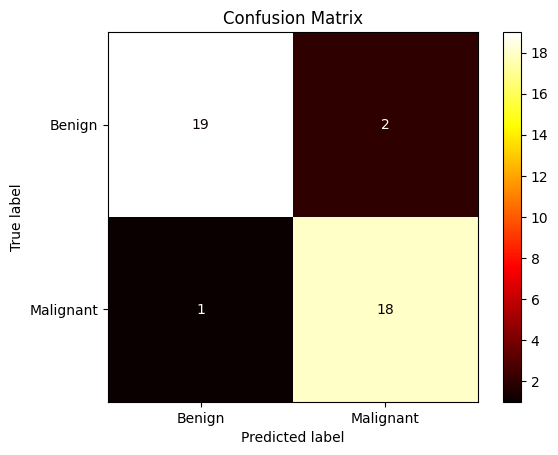

Fold 3 Accuracy: 0.9250, F1: 0.9231

===== Fold 4/5 =====
Epoch 01 | Train Acc: 0.6049 | Val Acc: 0.8500
Epoch 02 | Train Acc: 0.7963 | Val Acc: 0.7000
Epoch 03 | Train Acc: 0.7778 | Val Acc: 0.7000
Epoch 04 | Train Acc: 0.7840 | Val Acc: 0.7000
Epoch 05 | Train Acc: 0.8272 | Val Acc: 0.7000
Epoch 06 | Train Acc: 0.8210 | Val Acc: 0.7750
Epoch 07 | Train Acc: 0.8642 | Val Acc: 0.8000
Epoch 08 | Train Acc: 0.8765 | Val Acc: 0.8250
Epoch 09 | Train Acc: 0.8333 | Val Acc: 0.8250
Epoch 10 | Train Acc: 0.8765 | Val Acc: 0.8500
Epoch 11 | Train Acc: 0.9012 | Val Acc: 0.8000
Epoch 12 | Train Acc: 0.8889 | Val Acc: 0.8000
Epoch 13 | Train Acc: 0.9198 | Val Acc: 0.8500
Epoch 14 | Train Acc: 0.9074 | Val Acc: 0.8500
Epoch 15 | Train Acc: 0.9444 | Val Acc: 0.8500
Epoch 16 | Train Acc: 0.9198 | Val Acc: 0.8250
Epoch 17 | Train Acc: 0.9383 | Val Acc: 0.8250
Epoch 18 | Train Acc: 0.9568 | Val Acc: 0.8000
Epoch 19 | Train Acc: 0.9012 | Val Acc: 0.8500
Epoch 20 | Train Acc: 0.9198 | Val Acc: 0.8250
Ep

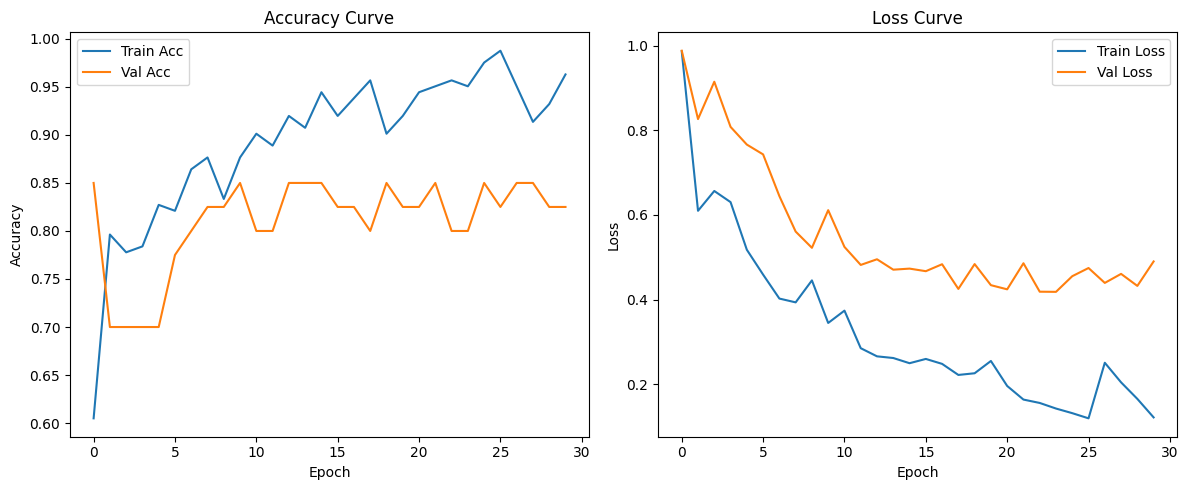

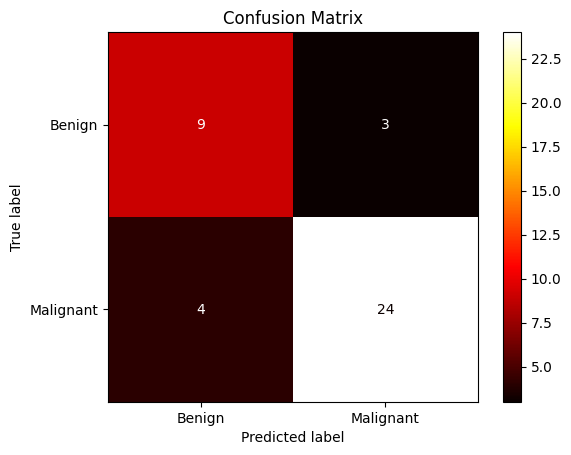

Fold 4 Accuracy: 0.8250, F1: 0.8727

===== Fold 5/5 =====
Epoch 01 | Train Acc: 0.6481 | Val Acc: 0.6750
Epoch 02 | Train Acc: 0.5988 | Val Acc: 0.6000
Epoch 03 | Train Acc: 0.6790 | Val Acc: 0.6000
Epoch 04 | Train Acc: 0.8025 | Val Acc: 0.6000
Epoch 05 | Train Acc: 0.7963 | Val Acc: 0.6000
Epoch 06 | Train Acc: 0.8210 | Val Acc: 0.8000
Epoch 07 | Train Acc: 0.8148 | Val Acc: 0.8250
Epoch 08 | Train Acc: 0.8272 | Val Acc: 0.8250
Epoch 09 | Train Acc: 0.8457 | Val Acc: 0.8250
Epoch 10 | Train Acc: 0.8395 | Val Acc: 0.8250
Epoch 11 | Train Acc: 0.8642 | Val Acc: 0.8250
Epoch 12 | Train Acc: 0.9198 | Val Acc: 0.7750
Epoch 13 | Train Acc: 0.8827 | Val Acc: 0.8000
Epoch 14 | Train Acc: 0.8580 | Val Acc: 0.8250
Epoch 15 | Train Acc: 0.9259 | Val Acc: 0.8250
Epoch 16 | Train Acc: 0.9136 | Val Acc: 0.8000
Epoch 17 | Train Acc: 0.8827 | Val Acc: 0.8000
Epoch 18 | Train Acc: 0.9259 | Val Acc: 0.8250
Early stopping


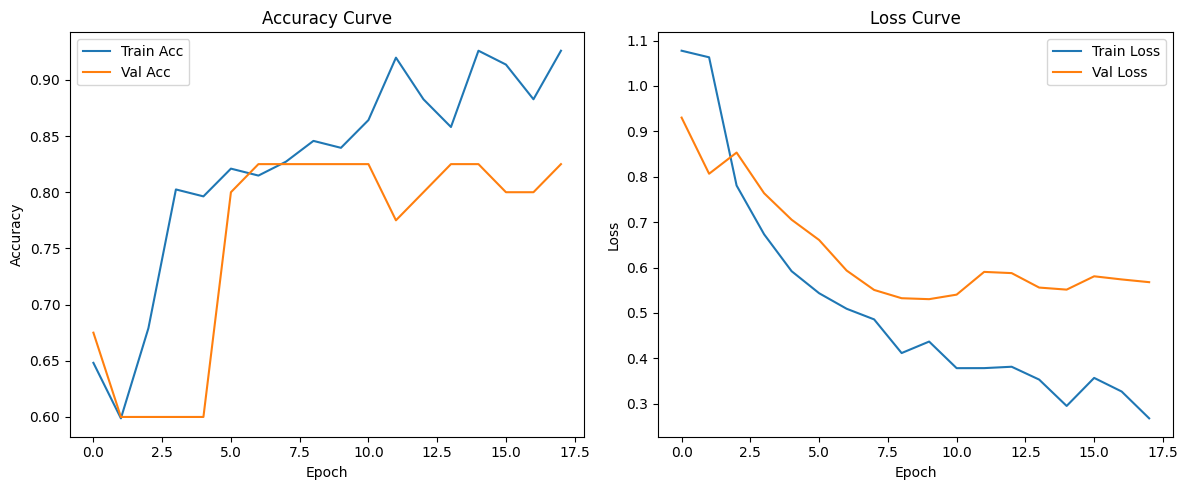

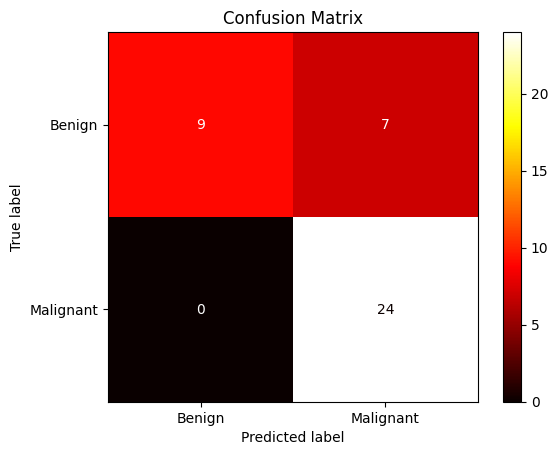

Fold 5 Accuracy: 0.8250, F1: 0.8727

===== Final Results =====
Mean Accuracy: 0.8613
Mean F1 Score: 0.8934


In [50]:


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary

# -----------------------------
# Device
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Improved CNN Model
# -----------------------------
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.1),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.1),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.1),
        )

        # Compute flattened size dynamically
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 128, 128)
            flat_size = self.features(dummy).view(1, -1).shape[1]

        self.classifier = nn.Sequential(
            nn.Linear(flat_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)  # NO sigmoid here
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# -----------------------------
# Initialize model
# -----------------------------
model = CNNModel().to(device)
summary(model, input_size=(1, 128, 128))

# -----------------------------
# Plotting utilities
# -----------------------------
def plot_metrics(train_acc, val_acc, train_loss, val_loss):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label="Train Acc")
    plt.plot(val_acc, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy Curve")

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curve")

    plt.tight_layout()
    plt.show()

def plot_confusion(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["Benign", "Malignant"])
    disp.plot(cmap=plt.cm.hot)
    plt.title("Confusion Matrix")
    plt.show()

# -----------------------------
# Prepare tensors
# -----------------------------
X_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
y_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

# -----------------------------
# K-Fold Cross Validation
# -----------------------------
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

accuracies, f1_scores = [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_tensor)):
    print(f"\n===== Fold {fold+1}/{k} =====")

    model = CNNModel().to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=3, factor=0.5
    )

    # Handle possible class imbalance
    pos_weight = torch.tensor([len(y_train) / (y_train.sum() + 1e-6)]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    train_ds = TensorDataset(X_tensor[train_idx], y_tensor[train_idx])
    val_ds = TensorDataset(X_tensor[val_idx], y_tensor[val_idx])

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=32)

    best_loss = float("inf")
    patience, patience_counter = 8, 0

    train_acc_list, val_acc_list = [], []
    train_loss_list, val_loss_list = [], []

    for epoch in range(30):
        # -------- Training --------
        model.train()
        correct, total, train_loss = 0, 0, 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * xb.size(0)
            preds = (torch.sigmoid(logits) > 0.5).float()
            correct += (preds == yb).sum().item()
            total += yb.size(0)

        train_loss /= total
        train_acc = correct / total

        # -------- Validation --------
        model.eval()
        correct, total, val_loss = 0, 0, 0
        y_true, y_pred = [], []

        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)
                val_loss += loss.item() * xb.size(0)

                preds = (torch.sigmoid(logits) > 0.5).float()
                correct += (preds == yb).sum().item()
                total += yb.size(0)

                y_true.extend(yb.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        val_loss /= total
        val_acc = correct / total
        scheduler.step(val_loss)

        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)

        print(f"Epoch {epoch+1:02d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            best_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break

    # -------- Evaluation --------
    model.load_state_dict(best_state)
    y_true = np.array(y_true).astype(int)
    y_pred = np.array(y_pred).astype(int)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    accuracies.append(acc)
    f1_scores.append(f1)

    plot_metrics(train_acc_list, val_acc_list, train_loss_list, val_loss_list)
    plot_confusion(y_true, y_pred)

    print(f"Fold {fold+1} Accuracy: {acc:.4f}, F1: {f1:.4f}")

print("\n===== Final Results =====")
print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
print(f"Mean F1 Score: {np.mean(f1_scores):.4f}")

Saving Trained CNN model

In [51]:
torch.save(model.state_dict(), 'cnn_model_best.pth')

Filter Extraction

Filters shape: torch.Size([32, 1, 3, 3])


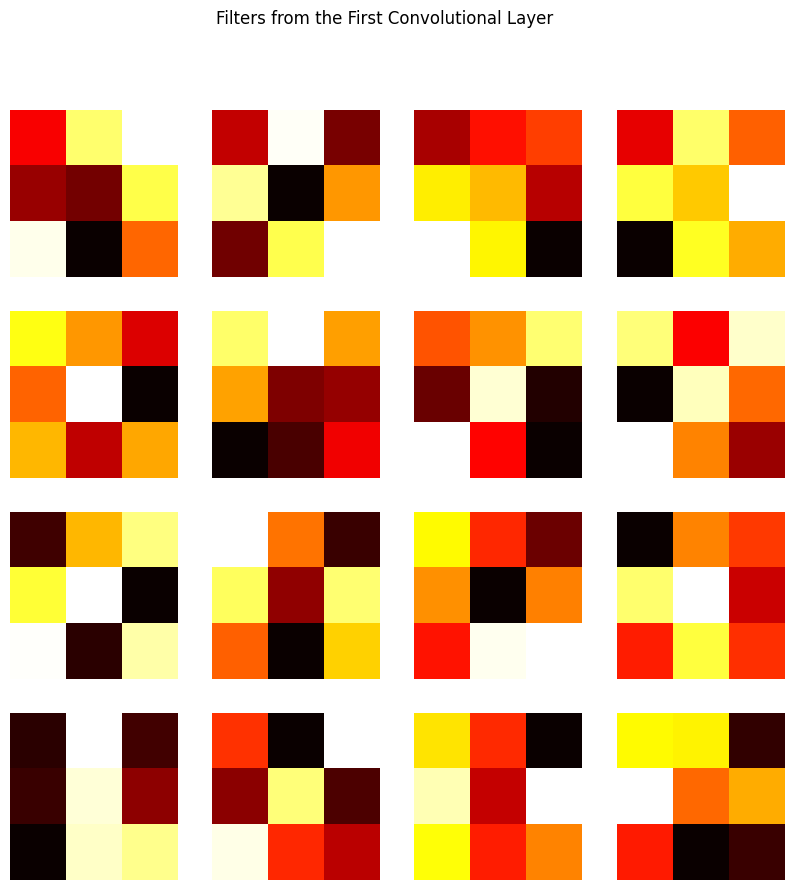

In [53]:
def visualize_filters(model):
    first_layer = model.features[0] # Corrected from model.conv1
    filters = first_layer.weight.data
    print(f"Filters shape: {filters.shape}")
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)

    plt.figure(figsize=(10, 10))
    n_filters = min(16, filters.shape[0])
    for i in range(n_filters):
        plt.subplot(4, 4, i + 1)
        plt.imshow(filters[i, 0, :, :], cmap='hot')
        plt.axis('off')
    plt.suptitle('Filters from the First Convolutional Layer')
    plt.show()
model = CNNModel()
visualize_filters(model)

ScatNet Model Creation and Training



===== Fold 1/5 =====
Epoch 01 | Train Acc: 0.5839 | Val Acc: 0.7317
Epoch 02 | Train Acc: 0.5839 | Val Acc: 0.7317
Epoch 03 | Train Acc: 0.5839 | Val Acc: 0.7317
Epoch 04 | Train Acc: 0.5839 | Val Acc: 0.7317
Epoch 05 | Train Acc: 0.5839 | Val Acc: 0.7317
Epoch 06 | Train Acc: 0.6025 | Val Acc: 0.7561
Epoch 07 | Train Acc: 0.6957 | Val Acc: 0.7561
Epoch 08 | Train Acc: 0.7329 | Val Acc: 0.7317
Epoch 09 | Train Acc: 0.7826 | Val Acc: 0.7805
Epoch 10 | Train Acc: 0.7888 | Val Acc: 0.7561
Epoch 11 | Train Acc: 0.7888 | Val Acc: 0.7317
Epoch 12 | Train Acc: 0.7826 | Val Acc: 0.7561
Epoch 13 | Train Acc: 0.7516 | Val Acc: 0.7561
Epoch 14 | Train Acc: 0.7391 | Val Acc: 0.7561
Epoch 15 | Train Acc: 0.7640 | Val Acc: 0.7561
Epoch 16 | Train Acc: 0.7702 | Val Acc: 0.7317
Epoch 17 | Train Acc: 0.8075 | Val Acc: 0.7561
Epoch 18 | Train Acc: 0.7826 | Val Acc: 0.7805
Epoch 19 | Train Acc: 0.8137 | Val Acc: 0.7805
Epoch 20 | Train Acc: 0.8012 | Val Acc: 0.7805
Epoch 21 | Train Acc: 0.7950 | Val Acc

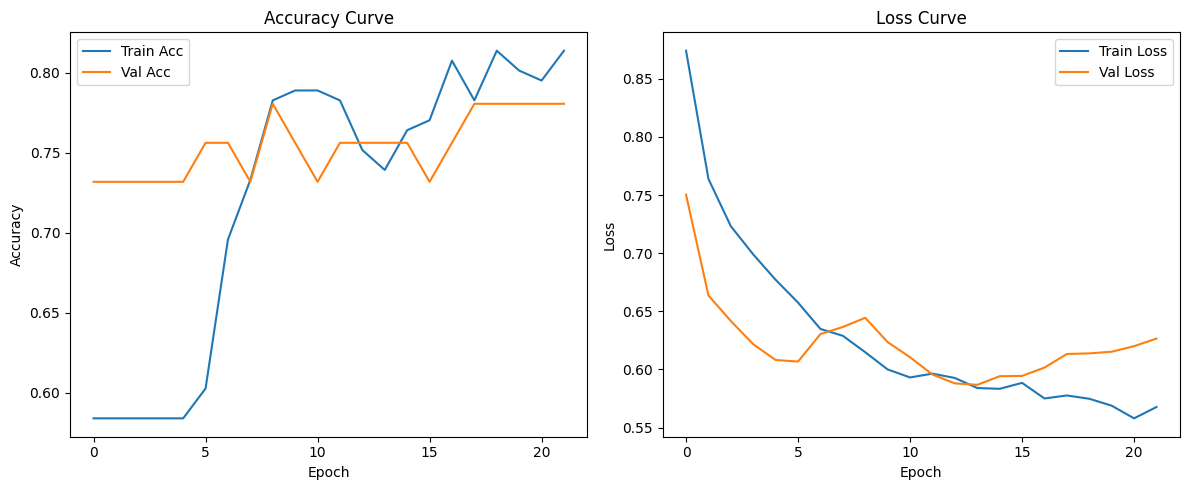

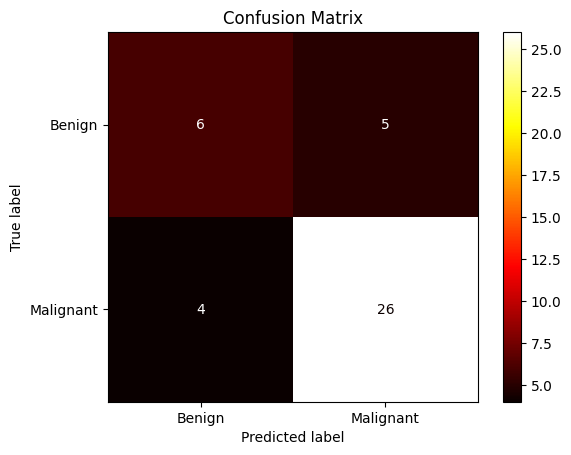

Fold 1 Accuracy: 0.7805, F1: 0.8525

===== Fold 2/5 =====
Epoch 01 | Train Acc: 0.6149 | Val Acc: 0.5610
Epoch 02 | Train Acc: 0.6273 | Val Acc: 0.5610
Epoch 03 | Train Acc: 0.6273 | Val Acc: 0.5610
Epoch 04 | Train Acc: 0.6273 | Val Acc: 0.5610
Epoch 05 | Train Acc: 0.6273 | Val Acc: 0.5610
Epoch 06 | Train Acc: 0.6273 | Val Acc: 0.5854
Epoch 07 | Train Acc: 0.6335 | Val Acc: 0.6098
Epoch 08 | Train Acc: 0.6832 | Val Acc: 0.6829
Epoch 09 | Train Acc: 0.7081 | Val Acc: 0.6829
Epoch 10 | Train Acc: 0.7081 | Val Acc: 0.6829
Epoch 11 | Train Acc: 0.7143 | Val Acc: 0.6829
Epoch 12 | Train Acc: 0.7391 | Val Acc: 0.6829
Epoch 13 | Train Acc: 0.7453 | Val Acc: 0.7561
Epoch 14 | Train Acc: 0.7764 | Val Acc: 0.7561
Epoch 15 | Train Acc: 0.7826 | Val Acc: 0.7317
Epoch 16 | Train Acc: 0.7950 | Val Acc: 0.7561
Epoch 17 | Train Acc: 0.8137 | Val Acc: 0.7805
Epoch 18 | Train Acc: 0.7950 | Val Acc: 0.7561
Epoch 19 | Train Acc: 0.8012 | Val Acc: 0.7561
Epoch 20 | Train Acc: 0.7578 | Val Acc: 0.7561
Ep

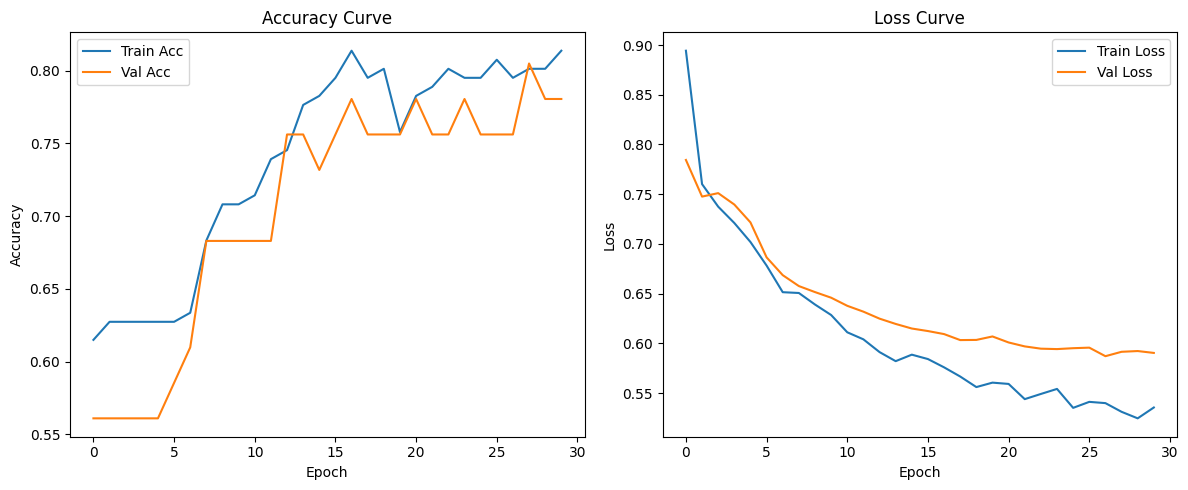

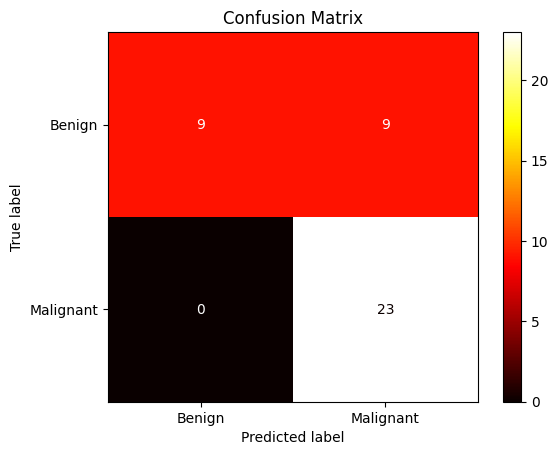

Fold 2 Accuracy: 0.7805, F1: 0.8364

===== Fold 3/5 =====
Epoch 01 | Train Acc: 0.6481 | Val Acc: 0.4750
Epoch 02 | Train Acc: 0.6481 | Val Acc: 0.4750
Epoch 03 | Train Acc: 0.6481 | Val Acc: 0.4750
Epoch 04 | Train Acc: 0.6481 | Val Acc: 0.4750
Epoch 05 | Train Acc: 0.6481 | Val Acc: 0.4750
Epoch 06 | Train Acc: 0.6481 | Val Acc: 0.4750
Epoch 07 | Train Acc: 0.6481 | Val Acc: 0.5000
Epoch 08 | Train Acc: 0.6790 | Val Acc: 0.5750
Epoch 09 | Train Acc: 0.7222 | Val Acc: 0.6250
Epoch 10 | Train Acc: 0.7099 | Val Acc: 0.5500
Epoch 11 | Train Acc: 0.7037 | Val Acc: 0.5500
Epoch 12 | Train Acc: 0.7160 | Val Acc: 0.6000
Epoch 13 | Train Acc: 0.7531 | Val Acc: 0.6750
Epoch 14 | Train Acc: 0.7531 | Val Acc: 0.6750
Epoch 15 | Train Acc: 0.7716 | Val Acc: 0.7250
Epoch 16 | Train Acc: 0.7901 | Val Acc: 0.6750
Epoch 17 | Train Acc: 0.7963 | Val Acc: 0.6750
Epoch 18 | Train Acc: 0.7778 | Val Acc: 0.7500
Epoch 19 | Train Acc: 0.8086 | Val Acc: 0.7500
Epoch 20 | Train Acc: 0.8086 | Val Acc: 0.7500
Ep

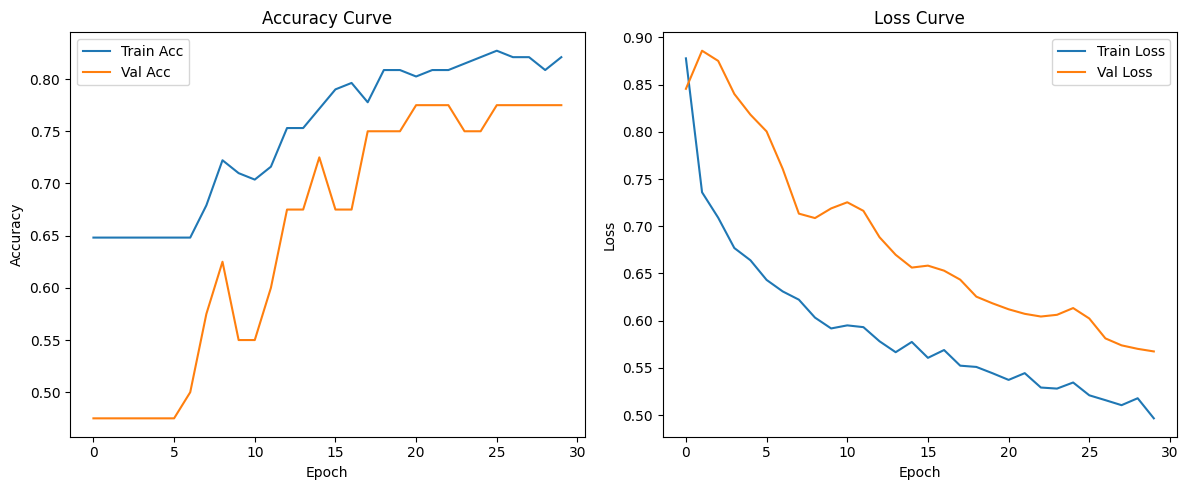

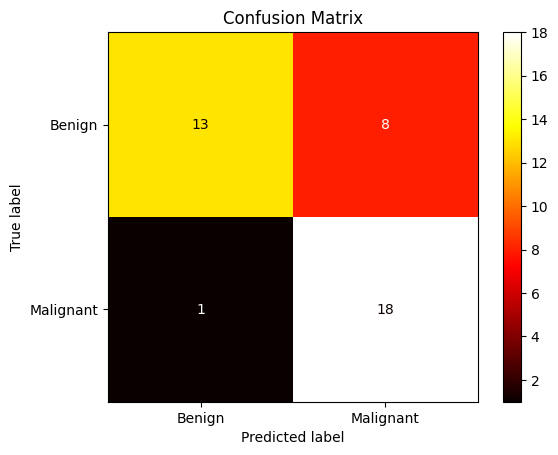

Fold 3 Accuracy: 0.7750, F1: 0.8000

===== Fold 4/5 =====
Epoch 01 | Train Acc: 0.5926 | Val Acc: 0.7000
Epoch 02 | Train Acc: 0.5926 | Val Acc: 0.7000
Epoch 03 | Train Acc: 0.5926 | Val Acc: 0.7000
Epoch 04 | Train Acc: 0.5926 | Val Acc: 0.7000
Epoch 05 | Train Acc: 0.5926 | Val Acc: 0.7000
Epoch 06 | Train Acc: 0.5988 | Val Acc: 0.7000
Epoch 07 | Train Acc: 0.6667 | Val Acc: 0.7000
Epoch 08 | Train Acc: 0.6914 | Val Acc: 0.7250
Epoch 09 | Train Acc: 0.7593 | Val Acc: 0.8000
Epoch 10 | Train Acc: 0.7840 | Val Acc: 0.8250
Epoch 11 | Train Acc: 0.7778 | Val Acc: 0.8250
Epoch 12 | Train Acc: 0.7716 | Val Acc: 0.8000
Epoch 13 | Train Acc: 0.7716 | Val Acc: 0.7750
Epoch 14 | Train Acc: 0.7716 | Val Acc: 0.8000
Epoch 15 | Train Acc: 0.7901 | Val Acc: 0.7750
Epoch 16 | Train Acc: 0.7840 | Val Acc: 0.7750
Epoch 17 | Train Acc: 0.8025 | Val Acc: 0.8500
Epoch 18 | Train Acc: 0.7963 | Val Acc: 0.8250
Epoch 19 | Train Acc: 0.7901 | Val Acc: 0.8250
Epoch 20 | Train Acc: 0.7963 | Val Acc: 0.8000
Ep

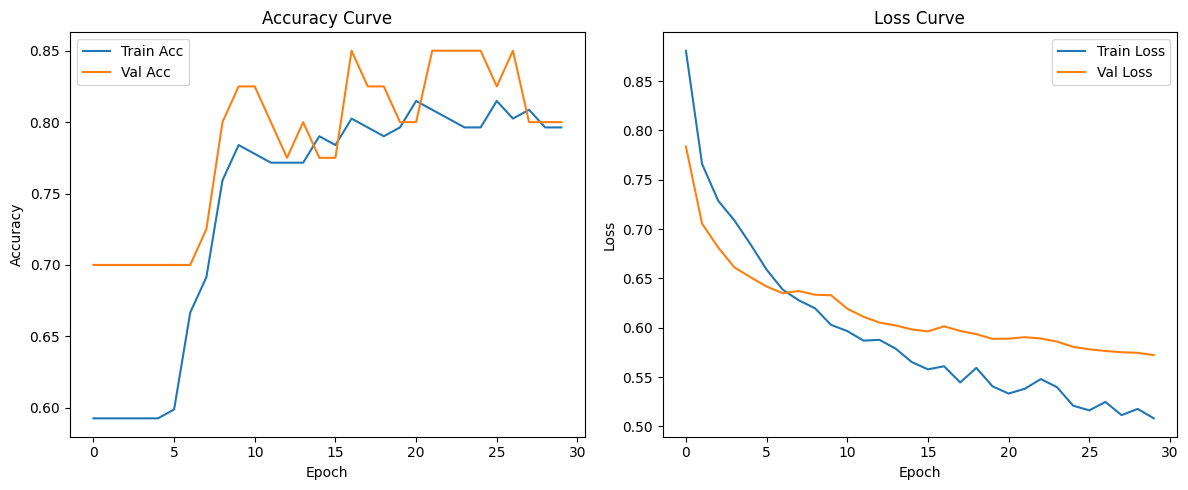

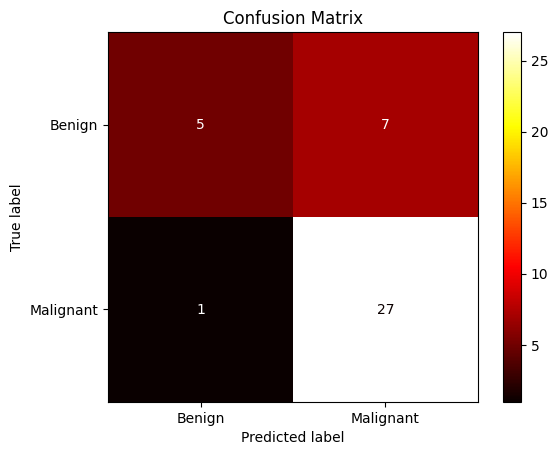

Fold 4 Accuracy: 0.8000, F1: 0.8710

===== Fold 5/5 =====
Epoch 01 | Train Acc: 0.6173 | Val Acc: 0.6000
Epoch 02 | Train Acc: 0.6173 | Val Acc: 0.6000
Epoch 03 | Train Acc: 0.6173 | Val Acc: 0.6000
Epoch 04 | Train Acc: 0.6173 | Val Acc: 0.6000
Epoch 05 | Train Acc: 0.6173 | Val Acc: 0.6000
Epoch 06 | Train Acc: 0.6173 | Val Acc: 0.6000
Epoch 07 | Train Acc: 0.6173 | Val Acc: 0.6000
Epoch 08 | Train Acc: 0.6173 | Val Acc: 0.6250
Epoch 09 | Train Acc: 0.6420 | Val Acc: 0.7250
Epoch 10 | Train Acc: 0.6605 | Val Acc: 0.7250
Epoch 11 | Train Acc: 0.6728 | Val Acc: 0.7500
Epoch 12 | Train Acc: 0.6914 | Val Acc: 0.7500
Epoch 13 | Train Acc: 0.7284 | Val Acc: 0.7500
Epoch 14 | Train Acc: 0.7037 | Val Acc: 0.7250
Epoch 15 | Train Acc: 0.6852 | Val Acc: 0.7000
Epoch 16 | Train Acc: 0.6852 | Val Acc: 0.7000
Epoch 17 | Train Acc: 0.6975 | Val Acc: 0.7250
Epoch 18 | Train Acc: 0.6914 | Val Acc: 0.7500
Epoch 19 | Train Acc: 0.7037 | Val Acc: 0.7500
Epoch 20 | Train Acc: 0.6852 | Val Acc: 0.7750
Ep

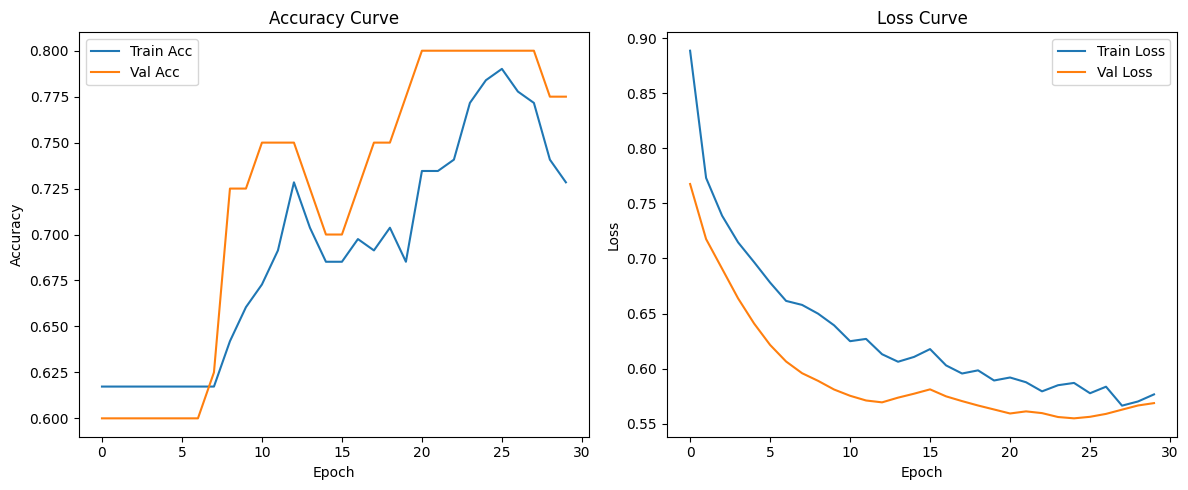

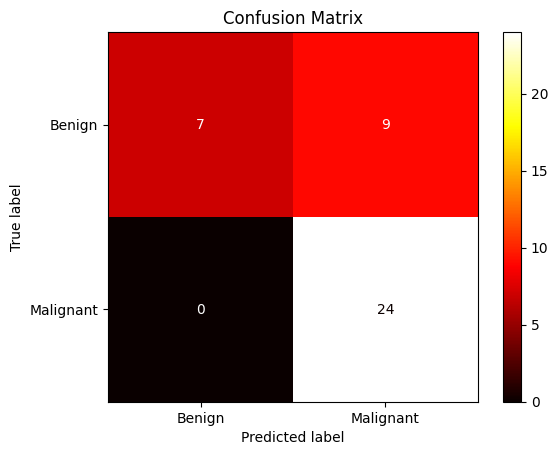

Fold 5 Accuracy: 0.7750, F1: 0.8421

===== Final ScatNet Results =====
Mean Accuracy: 0.7822 ± 0.0092
Mean F1 Score: 0.8404 ± 0.0234


In [56]:


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from kymatio.torch import Scattering2D

# -----------------------------
# Device
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Improved ScatNet Model
# -----------------------------
class ScatNetModel(nn.Module):
    def __init__(self, input_shape=(1, 128, 128)):
        super(ScatNetModel, self).__init__()

        self.scattering = Scattering2D(J=2, shape=input_shape[1:]).to(device)

        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape).to(device)
            scatter_out = self.scattering(dummy)
            flat_size = scatter_out.view(1, -1).shape[1]

        # SAME classifier as CNN (except input size)
        self.classifier = nn.Sequential(
            nn.Linear(flat_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)  # NO sigmoid
        )

    def forward(self, x):
        x = self.scattering(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# -----------------------------
# Plotting utilities
# -----------------------------
def plot_metrics(train_acc, val_acc, train_loss, val_loss):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label="Train Acc")
    plt.plot(val_acc, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy Curve")

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curve")

    plt.tight_layout()
    plt.show()

def plot_confusion(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["Benign", "Malignant"])
    disp.plot(cmap=plt.cm.hot)
    plt.title("Confusion Matrix")
    plt.show()

# -----------------------------
# Prepare tensors
# -----------------------------
X_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
y_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

# -----------------------------
# K-Fold Cross Validation
# -----------------------------
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

accuracies, f1_scores = [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_tensor)):
    print(f"\n===== Fold {fold+1}/{k} =====")

    model = ScatNetModel().to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=3, factor=0.5
    )

    # Handle class imbalance
    pos_weight = torch.tensor([len(y_train) / (y_train.sum() + 1e-6)]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    train_ds = TensorDataset(X_tensor[train_idx], y_tensor[train_idx])
    val_ds = TensorDataset(X_tensor[val_idx], y_tensor[val_idx])

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=32)

    best_loss = float("inf")
    patience, patience_counter = 8, 0

    train_acc_list, val_acc_list = [], []
    train_loss_list, val_loss_list = [], []

    for epoch in range(30):
        # -------- Training --------
        model.train()
        correct, total, train_loss = 0, 0, 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * xb.size(0)
            preds = (torch.sigmoid(logits) > 0.5).float()
            correct += (preds == yb).sum().item()
            total += yb.size(0)

        train_loss /= total
        train_acc = correct / total

        # -------- Validation --------
        model.eval()
        correct, total, val_loss = 0, 0, 0
        y_true, y_pred = [], []

        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)
                val_loss += loss.item() * xb.size(0)

                preds = (torch.sigmoid(logits) > 0.5).float()
                correct += (preds == yb).sum().item()
                total += yb.size(0)

                y_true.extend(yb.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        val_loss /= total
        val_acc = correct / total
        scheduler.step(val_loss)

        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)

        print(f"Epoch {epoch+1:02d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            best_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break

    # -------- Evaluation --------
    model.load_state_dict(best_state)
    y_true = np.array(y_true).astype(int)
    y_pred = np.array(y_pred).astype(int)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    accuracies.append(acc)
    f1_scores.append(f1)

    plot_metrics(train_acc_list, val_acc_list, train_loss_list, val_loss_list)
    plot_confusion(y_true, y_pred)

    print(f"Fold {fold+1} Accuracy: {acc:.4f}, F1: {f1:.4f}")

print("\n===== Final ScatNet Results =====")
print(f"Mean Accuracy: {np.mean(accuracies):.4f} \u00b1 {np.std(accuracies):.4f}")
print(f"Mean F1 Score: {np.mean(f1_scores):.4f} \u00b1 {np.std(f1_scores):.4f}")

In [57]:
torch.save(model.state_dict(), "scatnet_model.pth")
print("Saved last trained model as 'scatnet_model.pth'")

Saved last trained model as 'scatnet_model.pth'


Filter Extraction

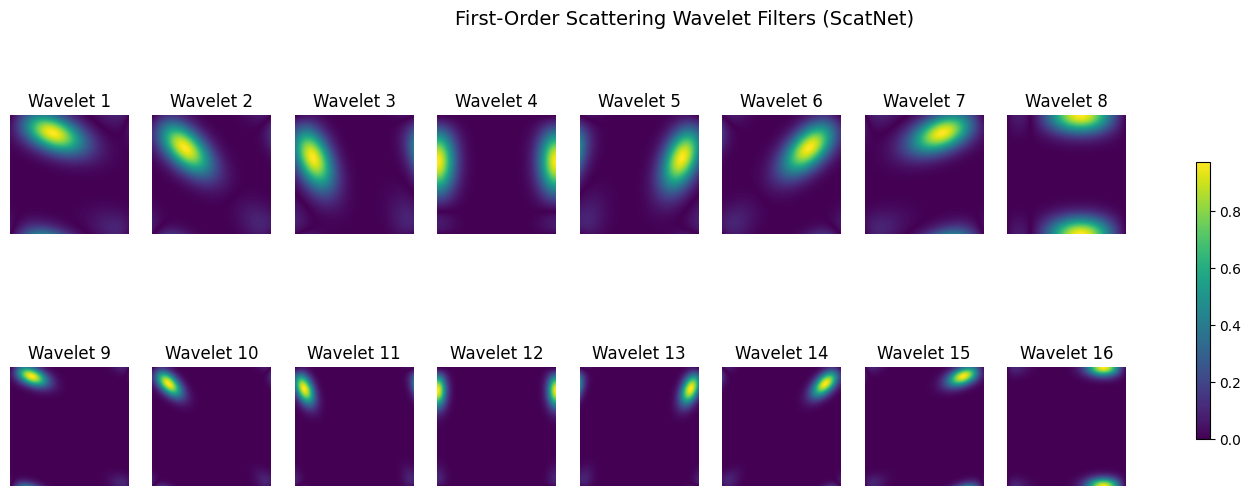

In [60]:


import numpy as np
import matplotlib.pyplot as plt
from kymatio.scattering2d.filter_bank import filter_bank

# -----------------------------
# Scattering parameters
# -----------------------------
J = 2               # Number of scales
L = 8               # Number of orientations
shape = (128, 128)  # Input image size

# -----------------------------
# Generate Scattering filters
# -----------------------------
filters = filter_bank(M=shape[0], N=shape[1], J=J, L=L)

# Extract first-order wavelet filters
first_order_wavelets = [psi['levels'][0] for psi in filters['psi']]

# -----------------------------
# Plot filters (publication quality)
# -----------------------------
n_filters = len(first_order_wavelets)
rows = 2
cols = n_filters // rows

fig, axes = plt.subplots(rows, cols, figsize=(18, 6))

for i, wavelet in enumerate(first_order_wavelets):
    ax = axes[i // cols, i % cols]
    im = ax.imshow(np.abs(wavelet), cmap="viridis")
    ax.set_title(f"Wavelet {i+1}")
    ax.axis("off")

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
plt.suptitle("First-Order Scattering Wavelet Filters (ScatNet)", fontsize=14)
plt.show()


In [59]:
!pip install captum

Deep Lift SHAP and Occlussion Implimentation For ScatNet - Captum Library

In [61]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import DeepLiftShap, Occlusion
from kymatio.torch import Scattering2D

# ScatNet Model in PyTorch
class ScatNetTorch(nn.Module):
    def __init__(self, input_shape):
        super(ScatNetTorch, self).__init__()
        self.scattering = Scattering2D(J=2, shape=(input_shape[1], input_shape[2]))

        # output shape
        with torch.no_grad():
            dt_input = torch.zeros(1, *input_shape)  # Shape: (1, 1, 128, 128)
            scatter_out = self.scattering(dt_input)  # Apply scattering
            self.feature_size = scatter_out.numel() // scatter_out.shape[0]  # Flatten size per sample

        # classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_size, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.scattering(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x)

# Instantiate ScatNet Model
input_shape = (1, 128, 128)
scatnet_torch_model = ScatNetTorch(input_shape)
scatnet_torch_model.eval()

ScatNetTorch(
  (scattering): Scattering2D()
  (classifier): Sequential(
    (0): Linear(in_features=82944, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

In [62]:
#  TensorFlow data to PyTorch tensor
def tf_to_torch(tensor):
    return torch.tensor(tensor).permute(0, 3, 1, 2).float()


input_tensor = X_test[:1]  # Select first test image
input_tensor_torch = tf_to_torch(input_tensor)
input_tensor_torch.requires_grad_()

# Create multiple baseline for SHAP
num_baselines = 5
reference_input = np.zeros((num_baselines, 128, 128, 1), dtype=np.float32)
reference_input_torch = tf_to_torch(reference_input)

/usr/local/lib/python3.12/dist-packages/captum/attr/_core/deep_lift.py:810: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  attributions = super().attribute.__wrapped__(  # type: ignore


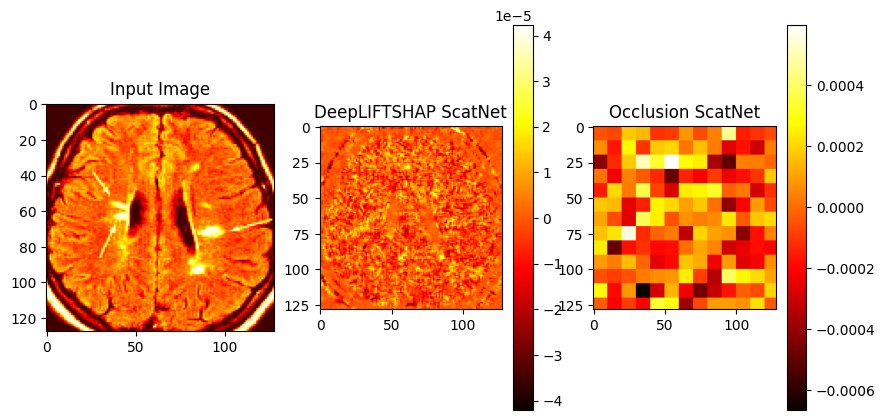

In [63]:
# Apply DeepLIFT
deep_lift = DeepLiftShap(scatnet_torch_model)
deep_lift_shap_scatnet_captum = deep_lift.attribute(input_tensor_torch, baselines=reference_input_torch).squeeze().detach().numpy()

# Apply Occlusion
occlusion = Occlusion(scatnet_torch_model)
occlusion_scatnet_captum = occlusion.attribute(input_tensor_torch, strides=(1, 10, 10), sliding_window_shapes=(1, 10, 10)).squeeze().detach().numpy()
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(input_tensor[0, :, :, 0], cmap='hot')
plt.subplot(1, 3, 2)
plt.title("DeepLIFTSHAP ScatNet")
plt.imshow(deep_lift_shap_scatnet_captum.reshape(128, 128), cmap='hot')
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title("Occlusion ScatNet")
plt.imshow(occlusion_scatnet_captum.reshape(128, 128), cmap='hot')
plt.colorbar()
plt.show()

DeepLIFT SHAP and Occlusion Implimentation CNN - Captum Library

In [64]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import DeepLiftShap, Occlusion

# CNN Model in PyTorch
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Conv Layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(2)
        self.drop1 = nn.Dropout(0.25)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2)
        self.drop2 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.pool3 = nn.MaxPool2d(2)
        self.drop3 = nn.Dropout(0.25)

        # Dynamically calculate flattened size
        self._to_linear = None
        self._get_flattened_size()

        # FC Layers
        self.fc1 = nn.Linear(self._to_linear, 128)
        self.drop_fc = nn.Dropout(0.5)
        self.out = nn.Linear(128, 1)

    def _get_flattened_size(self):
        with torch.no_grad():
            sample = torch.zeros(1, 1, 128, 128)
            x = F.relu(self.conv1(sample))
            x = self.pool1(x)
            x = self.drop1(x)
            x = F.relu(self.conv2(x))
            x = self.pool2(x)
            x = self.drop2(x)
            x = F.relu(self.conv3(x))
            x = self.pool3(x)
            x = self.drop3(x)
            self._to_linear = x.view(1, -1).shape[1]

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.drop1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.drop2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.drop3(x)
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.drop_fc(x)
        return torch.sigmoid(self.out(x))
# Instantiate CNN Model
cnn_torch_model = CNNModel()
cnn_torch_model.eval()

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=25088, out_features=128, bias=True)
  (drop_fc): Dropout(p=0.5, inplace=False)
  (out): Linear(in_features=128, out_features=1, bias=True)
)

In [65]:
def tf_to_torch(tensor):
    return torch.tensor(tensor).permute(0, 3, 1, 2).float()


input_tensor = X_test[:1]
input_tensor_torch = tf_to_torch(input_tensor)
input_tensor_torch.requires_grad_()

# multiple baseline for SHAP)
reference_input = np.zeros((5, 128, 128, 1), dtype=np.float32)
reference_input_torch = tf_to_torch(reference_input)
deep_lift = DeepLiftShap(cnn_torch_model)
deep_lift_shap_cnn_captum = deep_lift.attribute(input_tensor_torch, reference_input_torch).squeeze().detach().numpy()
occlusion = Occlusion(cnn_torch_model)
occlusion_cnn_captum = occlusion.attribute(input_tensor_torch, strides=(1, 10, 10), sliding_window_shapes=(1, 10, 10)).squeeze().detach().numpy()

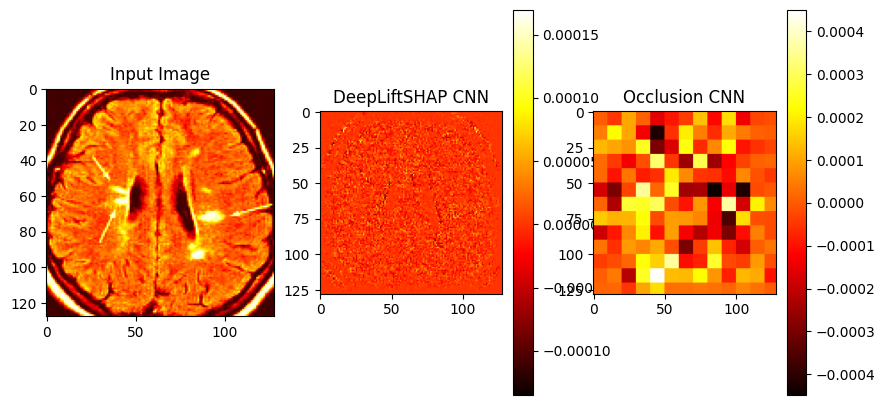

In [66]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(input_tensor[0, :, :, 0], cmap='hot')
plt.subplot(1, 3, 2)
plt.title("DeepLiftSHAP CNN")
plt.imshow(deep_lift_shap_cnn_captum.reshape(128, 128), cmap='hot')
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title("Occlusion CNN")
plt.imshow(occlusion_cnn_captum.reshape(128, 128), cmap='hot')
plt.colorbar()
plt.show()

Deep Lift SHAP and Occlusion For ScatNet Model - Manual Implimentation

In [67]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from kymatio.torch import Scattering2D

class ScatNetTorch(nn.Module):
    def __init__(self, input_shape):
        super(ScatNetTorch, self).__init__()
        self.scattering = Scattering2D(J=2, shape=(input_shape[1], input_shape[2]))

        # output shape
        with torch.no_grad():
            dt_input = torch.zeros(1, *input_shape)
            scatter_out = self.scattering(dt_input)
            self.feature_size = scatter_out.numel() // scatter_out.shape[0]

        # classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_size, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.scattering(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x)

input_shape = (1, 128, 128)
scatnet_torch_model = ScatNetTorch(input_shape)
scatnet_torch_model.eval()

ScatNetTorch(
  (scattering): Scattering2D()
  (classifier): Sequential(
    (0): Linear(in_features=82944, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

In [68]:
def tf_to_torch(tensor):
    return torch.tensor(tensor).permute(0, 3, 1, 2).float()


input_tensor = X_test[:1]
input_tensor_torch = tf_to_torch(input_tensor)
input_tensor_torch.requires_grad_()

# Create a baseline for Shap
num_baselines = 5
reference_input = np.zeros((num_baselines, 128, 128, 1), dtype=np.float32)
reference_input_torch = tf_to_torch(reference_input)



def manual_deeplift_shap(model, input_tensor, baseline_tensor_batch):
    model.eval()
    input_tensor = input_tensor.clone().detach().requires_grad_(True)

    all_attributions = []

    for i in range(baseline_tensor_batch.shape[0]):
        baseline = baseline_tensor_batch[i:i+1].clone().detach().requires_grad_(True)

        # Forward pass
        output_input = model(input_tensor)
        output_baseline = model(baseline)

        # Backward for input
        model.zero_grad()
        output_input.backward(torch.ones_like(output_input), retain_graph=True)
        grads_input = input_tensor.grad.clone()

        # Backward for baseline
        input_tensor.grad.zero_()  # Clear previous grad
        model.zero_grad()
        output_baseline.backward(torch.ones_like(output_baseline))
        grads_baseline = baseline.grad.clone()

        # Attribution: (input - baseline) * (grad_input - grad_baseline)
        attr = (input_tensor - baseline) * (grads_input - grads_baseline)
        all_attributions.append(attr.detach())

    # Average over baselines
    shap_attr = torch.mean(torch.stack(all_attributions), dim=0)
    return shap_attr.squeeze().numpy()


def manual_occlusion(model, input_tensor, window_size=(1,10,10), stride=(1,10,10)):
    input_clone = input_tensor.clone()
    baseline_value = 0.0
    _, c, h, w = input_tensor.shape
    output_original = model(input_tensor).item()
    occlusion_map = np.zeros((h, w), dtype=np.float32)

    for i in range(0, h, stride[1]):
        for j in range(0, w, stride[2]):
            input_occluded = input_clone.clone()
            i_end = min(i + window_size[1], h)
            j_end = min(j + window_size[2], w)
            input_occluded[:, :, i:i_end, j:j_end] = baseline_value
            with torch.no_grad():
                output = model(input_occluded).item()
            occlusion_map[i:i_end, j:j_end] += output_original - output

    return occlusion_map

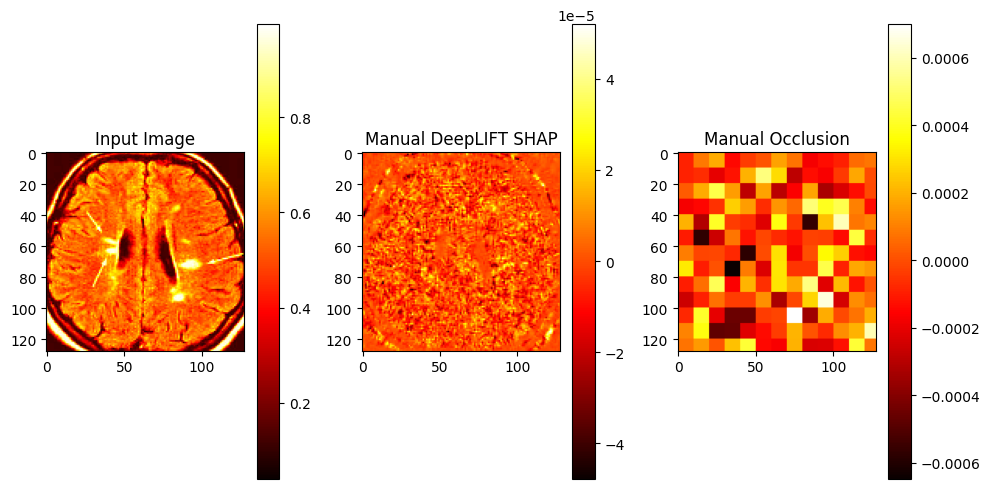

In [69]:
deep_lift_shap_scatnet_manual = manual_deeplift_shap(scatnet_torch_model, input_tensor_torch, reference_input_torch)

occlussion_scatnet_manual = manual_occlusion(scatnet_torch_model, input_tensor_torch)


plt.figure(figsize=(10, 5))

# Input Image
input_img_np = input_tensor_torch.squeeze().detach().cpu().numpy()
if input_img_np.ndim == 3:
    input_img_np = input_img_np[0]

plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(input_img_np, cmap='hot')
plt.colorbar()

# DeepLIFT SHAP Result
plt.subplot(1, 3, 2)
plt.title("Manual DeepLIFT SHAP")
plt.imshow(deep_lift_shap_scatnet_manual.reshape(128, 128), cmap='hot')
plt.colorbar()

# Occlusion Result
plt.subplot(1, 3, 3)
plt.title("Manual Occlusion")
plt.imshow(occlussion_scatnet_manual, cmap='hot')
plt.colorbar()

plt.tight_layout()
plt.show()

Deep LIFT SHAP and Occlussion for CNN Model - Manual Implimentation

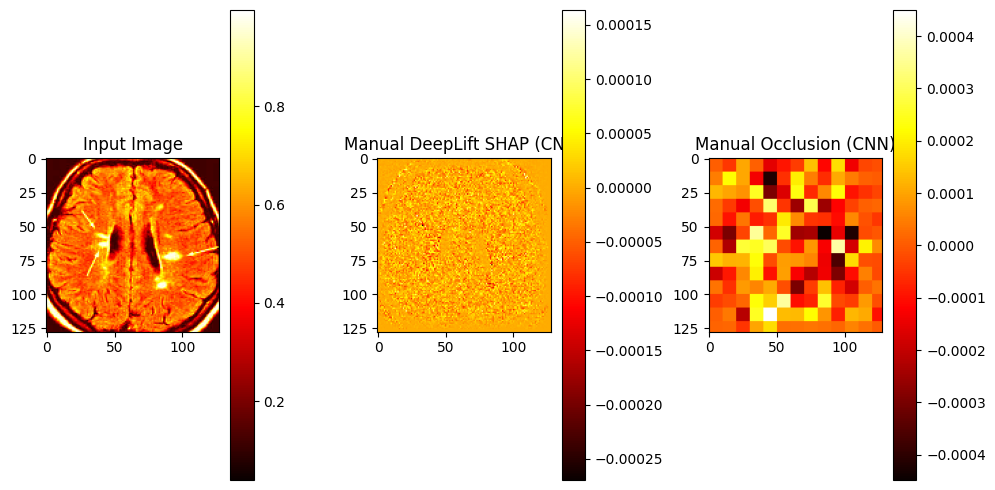

In [70]:
import torch.nn.functional as F

#Manual DeepLIFT SHAP
def manual_deeplift_shap(model, input_tensor, baseline_tensor_batch):
    model.eval()
    input_tensor = input_tensor.clone().detach().requires_grad_(True)

    all_attributions = []

    for i in range(baseline_tensor_batch.shape[0]):
        baseline = baseline_tensor_batch[i:i+1].clone().detach().requires_grad_(True)

        # Forward pass
        output_input = model(input_tensor)
        output_baseline = model(baseline)

        # Backward for input
        model.zero_grad()
        output_input.backward(torch.ones_like(output_input), retain_graph=True)
        grads_input = input_tensor.grad.clone()

        # Backward for baseline
        input_tensor.grad.zero_()  # Clear previous grad
        model.zero_grad()
        output_baseline.backward(torch.ones_like(output_baseline))
        grads_baseline = baseline.grad.clone()

        # Attribution: (input - baseline) * (grad_input - grad_baseline)
        attr = (input_tensor - baseline) * (grads_input - grads_baseline)
        all_attributions.append(attr.detach())

    # Average over baselines
    shap_attr = torch.mean(torch.stack(all_attributions), dim=0)
    return shap_attr.squeeze().numpy()

def tf_to_torch(tensor):
    return torch.tensor(tensor).permute(0, 3, 1, 2).float()


input_tensor = X_test[:1]
input_tensor_torch = tf_to_torch(input_tensor)
input_tensor_torch.requires_grad_()

# Create a baseline
num_baselines = 5
reference_input = np.zeros((num_baselines, 128, 128, 1), dtype=np.float32)
reference_input_torch = tf_to_torch(reference_input)


deep_lift_shap_cnn_manual = manual_deeplift_shap(cnn_torch_model, input_tensor_torch, reference_input_torch)


def manual_occlusion(model, input_tensor, window_size=10, stride=10, baseline_value=0.0):
    input_clone = input_tensor.clone()
    _, c, h, w = input_clone.shape
    attribution = torch.zeros_like(input_clone)

    for i in range(0, h, stride):
        for j in range(0, w, stride):
            # Create a copy of the input with occluded patch
            occluded = input_clone.clone()
            occluded[:, :, i:i+window_size, j:j+window_size] = baseline_value

            # Get difference in output
            output_orig = model(input_clone).item()
            output_occ = model(occluded).item()
            delta = output_orig - output_occ

            # Assign attribution score to the occluded region
            attribution[:, :, i:i+window_size, j:j+window_size] += delta

    return attribution.squeeze().detach().cpu().numpy()

manual_occ_attr_CNN = manual_occlusion(cnn_torch_model, input_tensor_torch, window_size=10, stride=10)


plt.figure(figsize=(10, 5))

# Input image
input_img_np = input_tensor_torch.squeeze().detach().cpu().numpy()
if input_img_np.ndim == 3:
    input_img_np = input_img_np[0]  # Take only the first channel if needed

plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(input_img_np, cmap='hot')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Manual DeepLift SHAP (CNN)")
plt.imshow(deep_lift_shap_cnn_manual.reshape(128, 128), cmap='hot')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Manual Occlusion (CNN)")
plt.imshow(manual_occ_attr_CNN.reshape(128, 128), cmap='hot')
plt.colorbar()

plt.tight_layout()
plt.show()

CNN Deep LIFT SHAP and Occlusion Comparison

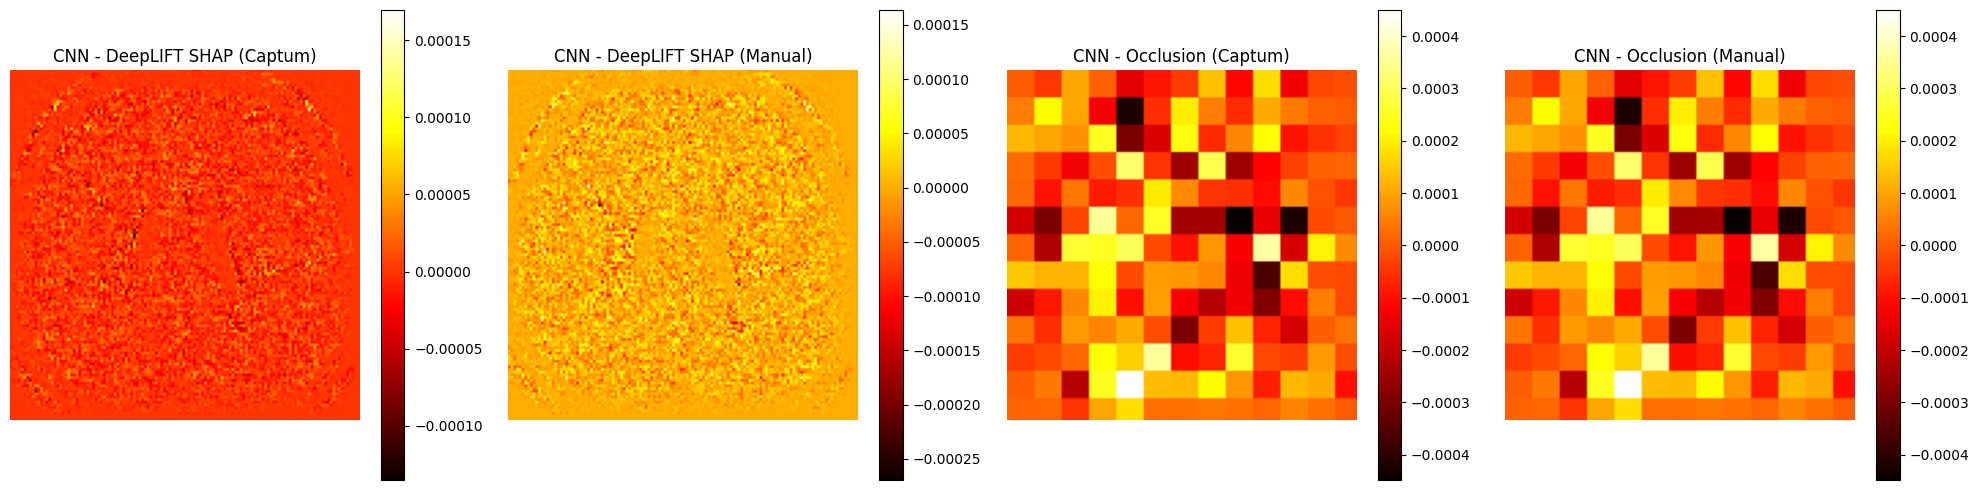

In [71]:
import matplotlib.pyplot as plt

# Ensure attribution shape is correct
def preprocess_attr(attr):
    if isinstance(attr, torch.Tensor):
        attr = attr.detach().cpu().numpy()
    if len(attr.shape) == 4:
        return attr.squeeze(0).squeeze(0)
    elif len(attr.shape) == 3:
        return attr.squeeze(0)
    return attr

# Preprocess all attribution maps
attributions = [
    preprocess_attr(deep_lift_shap_cnn_captum),
    preprocess_attr(deep_lift_shap_cnn_manual),
    preprocess_attr(occlusion_cnn_captum),
    preprocess_attr(manual_occ_attr_CNN)
]

# Titles
titles = [
    "CNN - DeepLIFT SHAP (Captum)",
    "CNN - DeepLIFT SHAP (Manual)",
    "CNN - Occlusion (Captum)",
    "CNN - Occlusion (Manual)"
]

# Plot comparison
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, ax in enumerate(axes.flat):
    img = ax.imshow(attributions[i], cmap='hot')
    ax.set_title(titles[i])
    ax.axis("off")
    fig.colorbar(img, ax=ax)

plt.tight_layout()
plt.show()

Deep LIFT SHAP and Occlusion Comparison Manual VS Captum

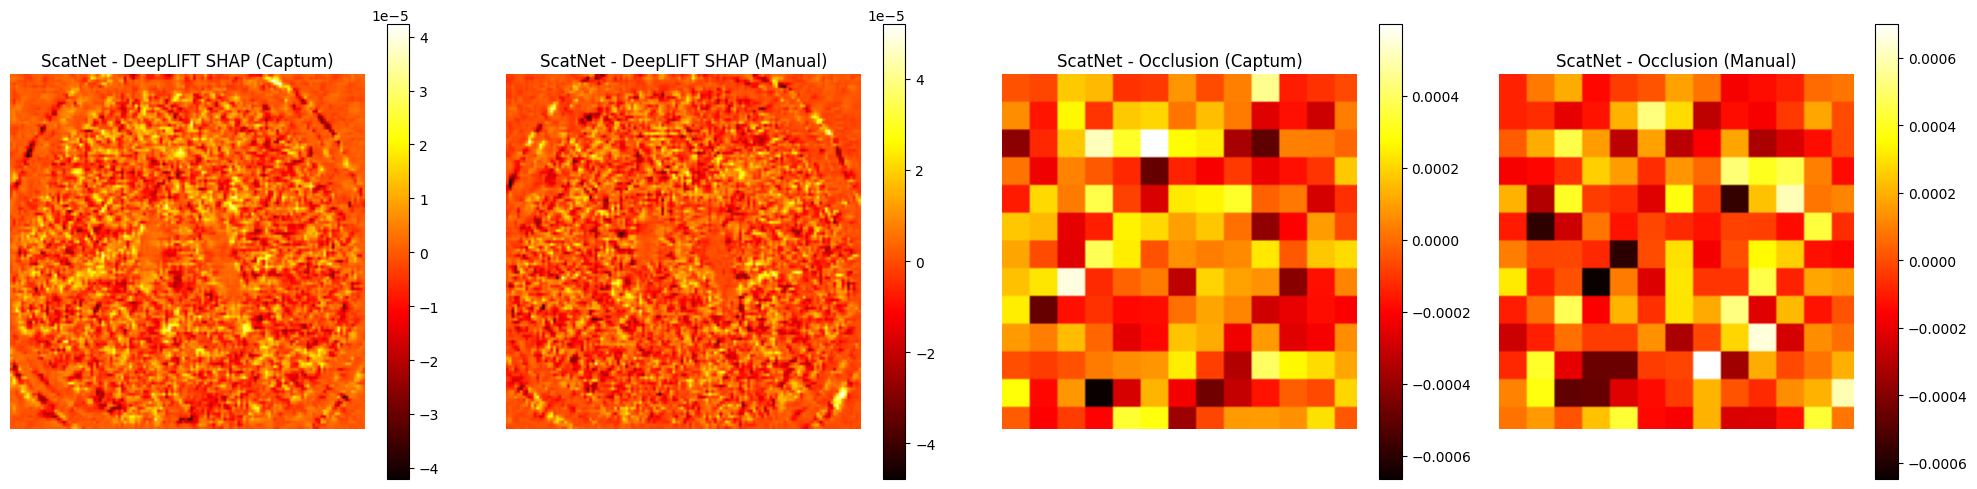

In [72]:
import matplotlib.pyplot as plt

def preprocess_attr(attr):
    if isinstance(attr, torch.Tensor):
        attr = attr.detach().cpu().numpy()
    if len(attr.shape) == 4:
        return attr.squeeze(0).squeeze(0)
    elif len(attr.shape) == 3:
        return attr.squeeze(0)
    return attr

attributions_scatnet = [
    preprocess_attr(deep_lift_shap_scatnet_captum),
    preprocess_attr(deep_lift_shap_scatnet_manual),
    preprocess_attr(occlusion_scatnet_captum),
    preprocess_attr(occlussion_scatnet_manual)
]

titles_scatnet = [
    "ScatNet - DeepLIFT SHAP (Captum)",
    "ScatNet - DeepLIFT SHAP (Manual)",
    "ScatNet - Occlusion (Captum)",
    "ScatNet - Occlusion (Manual)"
]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, ax in enumerate(axes.flat):
    img = ax.imshow(attributions_scatnet[i], cmap='hot')
    ax.set_title(titles_scatnet[i])
    ax.axis("off")
    fig.colorbar(img, ax=ax)

plt.tight_layout()
plt.show()
